<a href="https://colab.research.google.com/github/Motz224/Pokemon_DCGANModel_20230803/blob/main/Pokemon_GANModel_20230804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from tensorflow.keras import layers
import time
from IPython import display

import shutil

In [ ]:
#Constant
BATCH_SIZE = 32
IMAGE_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#load image
import pathlib

_URL = "https://pds-workshop-data.s3.ap-southeast-1.amazonaws.com/pokemon_jpg.zip"
path_to_zip = tf.keras.utils.get_file(
    fname="pokemon_jpg.zip",
    origin=_URL,
    extract=True)
#path_to_zip  = pathlib.Path(path_to_zip)

#PATH = path_to_zip.parent / "pokemon_jpg"

base_dir = os.path.join(os.path.dirname(path_to_zip), 'pokemon_jpg')

33236017/33236017 [==============================] - 4s 0us/step


In [ ]:
#split the image in train-0.8 validation-0.2

classes = ["train, validation"]
for cl in classes:
  img_path = os.path.join(base_dir)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))

  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

for t in train:
  if not os.path.exists(os.path.join(base_dir, 'train/1')):
    os.makedirs(os.path.join(base_dir, 'train/1'))
  shutil.move(t, os.path.join(base_dir, 'train/1'))

for v in val:
  if not os.path.exists(os.path.join(base_dir, 'val/1')):
    os.makedirs(os.path.join(base_dir, 'val/1'))
  shutil.move(v, os.path.join(base_dir, 'val/1'))

train, validation: 819 Images


In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels=None,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  #seed=1,
  #validation_split=0.2,
  #subset="training"
  )
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels=None,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  #seed=1,
  #validation_split=0.2,
  #subset="validation"
  )
train_dataset

Found 655 files belonging to 1 classes.
Found 164 files belonging to 1 classes.


<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
"""resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255)
])"""

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  """# Resize and rescale all datasets.
  ds = ds.map(lambda x: (resize_and_rescale(x)),
              num_parallel_calls=AUTOTUNE)"""

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  #ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True)
validation_dataset = prepare(validation_dataset)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
# [updated by Jason] missing pre-processing
def preprocess(image_batch):
  image_batch = tf.cast(image_batch, tf.float32)
  image_batch = image_batch / 127.5 - 1
  return image_batch

train_dataset = train_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
!ls /root/.keras/datasets/pokemon_jpg

train  val


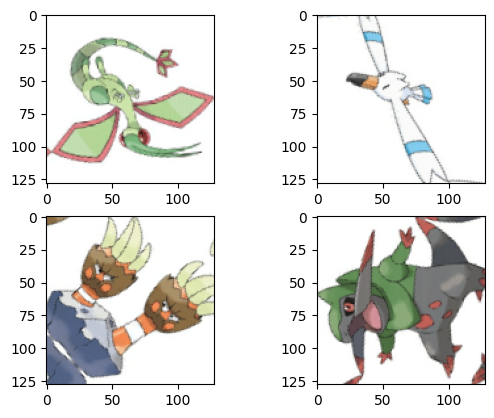

In [ ]:
# Visualize images from dataset
for batch in train_dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(((batch.numpy() + 1) / 2)[i])  # get in the range [0, 1] for visualizing
    break
plt.show()

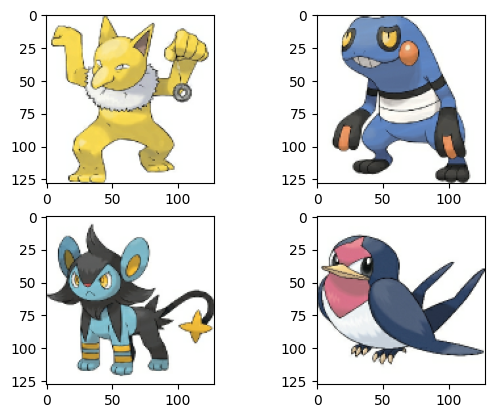

In [ ]:
# Visualize images from dataset
for batch in validation_dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(((batch.numpy() + 1) / 2)[i])  # get in the range [0, 1] for visualizing
    break
plt.show()

In [ ]:
def make_generator_model():
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=[noise_dim,]))

  model.add(layers.Dense(8*8*1024, use_bias=False))
  model.add(layers.Reshape((8, 8, 1024)))
  assert model.output_shape == (None, 8, 8, 1024)

  model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 16, 16, 512)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 32, 32, 256)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 64, 64, 128)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer, use_bias=False))
  assert model.output_shape == (None, 128, 128, 64)
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.ReLU())

  model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same',kernel_initializer=initializer, use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 128, 128, 3)

  return model

In [ ]:
def make_discriminator_model():
  initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=[128,128,3]))

  model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(1024, kernel_size=(5, 5), strides=(2, 2), padding="same",kernel_initializer=initializer, use_bias=False))
  model.add(layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6553600   
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      13107200  
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 512)      2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)     

In [ ]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        4800      
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                      

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      #plt.imshow(predictions[0, :, :,:])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    # images, label = images_data
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    #To show one of the loss
    global G_Loss, D_Loss
    G_Loss = gen_loss
    D_Loss = disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print(G_Loss, D_Loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)
  print(G_Loss, D_Loss)

In [ ]:
# checkpoint_dir = './drive/MyDrive/projects/training_checkpoints'
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

In [ ]:
#Since the file download from drive will be lossy compressed, the checkpoint cant restore
#checkpoint_dir = "./drive/MyDrive/DCGAN_20230408"

In [ ]:
#restore checkpoint


checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
#Save checkpt
checkpoint.save(file_prefix = checkpoint_prefix)
checkpoint_dir = './training_checkpoints'

In [ ]:
EPOCHS = 100

In [ ]:
train(train_dataset, 1)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
#processing gif
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

!pip install -q git+https://github.com/MJAHMADEE/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
#Generate
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :,:])

decision = discriminator(generated_image)
print (decision)